<a name="top"><h1>2.2. Predicciones Semanales</h1> </a>

<strong>Práctica Final : TOSCOS </strong><br />
<strong>Técnicas de Predicción: Series temporales</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong>

<p>&nbsp;</p>

<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>

<hr style="border:1px solid gray">

## Estructura

[1. Introducción](#introduccion)     

[2. Importación de librerias y carga de datos](#importacion)

[3. Análisis de la Serie Temporal](#analisis)

[4. Pruebas de modelos](#modelos)
    
   - Prophet
   - ETS
   - ARIMA
   - Theta
   - TBATS


[5. Predicción a futuro](#prediccion)      

<hr style="border:1px solid gray">

## <a name="introduccion"> 1. Introducción </a>

Una vez realizado el análisis exploratorio del dataset de TOSCOS en `1_EDA`, nos centraremos testear diferentes modelos y algorítmos de predicción para la serie temporal semanal, con el objetivo de seleccionar aquel que menor error tenga para predecir las ventas diarias desde el 1 de agosto de 2015 al 10 de septiembre de 2015.

## <a name="importacion"> 2. Importación de librerias y carga de datos <a>

Procedemos a cargar las librerias a utilizar:

In [1]:
# Import basic libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Import models.

from prophet import Prophet
from sktime.forecasting.ets import AutoETS # Modelo ETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error # Calcular  porcentaje MAE
from sktime.forecasting.exp_smoothing import ExponentialSmoothing # Modelo ETS manual
from sktime.transformations.series.boxcox import LogTransformer # Transforamción Logarítmica
from sktime.forecasting.arima import AutoARIMA # Modelo ARIMA
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.tbats import TBATS

# Import metrics and utilities.
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series # Graficar series
from sktime.forecasting.model_selection import temporal_train_test_split # Dividir dataset en train y test
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.performance_metrics.forecasting import MeanSquaredError # Calcular MAE
from statsmodels.tsa.seasonal import STL

# Ignore warnings.

import warnings
warnings.filterwarnings('ignore')


Procedemos a importar el dataset:

In [2]:
# Read the csv file.

data = pd.read_csv('../data/datos.csv')


# Convert the date column to datetime format.

data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Sort by date.

data = data.sort_values(by='Date', ascending=True)

# Separate Store  using the second and third letter into two new columns (Zone and type).

data['Zone'] = data['Store'].str[1:2]
data['Type'] = data['Store'].str[2:3]

#Resest the index.

data.reset_index(drop=True, inplace=True)

Transformamos la serie temporal a semanal:

In [3]:
# Gorup the data by date and sum the sales.

data = data.groupby(['Date']).sum().reset_index()

# Display the first 3 rows of data.

data.head(3)

,Date,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
0,2013-01-01,20,0,0,0,0,10
1,2013-01-02,30,61926,7490,9,0,10
2,2013-01-03,40,53588,6650,9,0,10


## <a name="analisis"> 3. Análisis de la Serie Temporal <a>

En este apartartado procederemos a convertir la serie temporal a semanal en primer lugar para posteriormente analizar sus características.

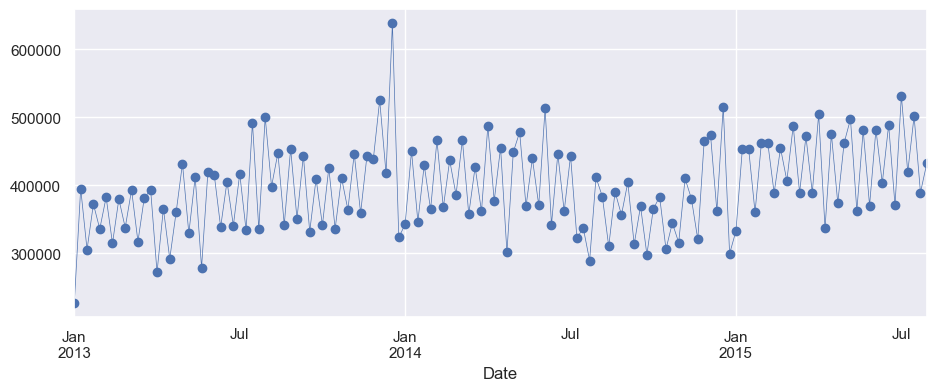

In [4]:
# Resample the data by week.

weekly = data.resample('W', on='Date').sum()

# Plot the data using seaborn.

sns.set(rc={'figure.figsize':(11, 4)})
weekly['Sales'].plot(marker='o', linestyle='-',linewidth=0.5);




Una vez representado el gráfico de las ventas semanales procedemos a utilizar el test de Dickey-Fuller para comprobar si existe estacionalidad.

In [21]:

# Function to test stationarity.

def test_stationarity(timeseries):
        
        #Perform Dickey-Fuller test:
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='BIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)


        

# Test stationarity.

test_stationarity(weekly['Sales'])


Results of Dickey-Fuller Test:
Test Statistic                  -5.356776
p-value                          0.000004
#Lags Used                       1.000000
Number of Observations Used    133.000000
Critical Value (1%)             -3.480500
Critical Value (5%)             -2.883528
Critical Value (10%)            -2.578496
dtype: float64


Observamos como una vez realizado el test de Dickey-Fuller el p-valor es menor que el nivel de significación (5%), por lo que confirmamos que nuestra serie temporal semanal es estacionaria. Procedemos a descomponerla para visualizarlo:

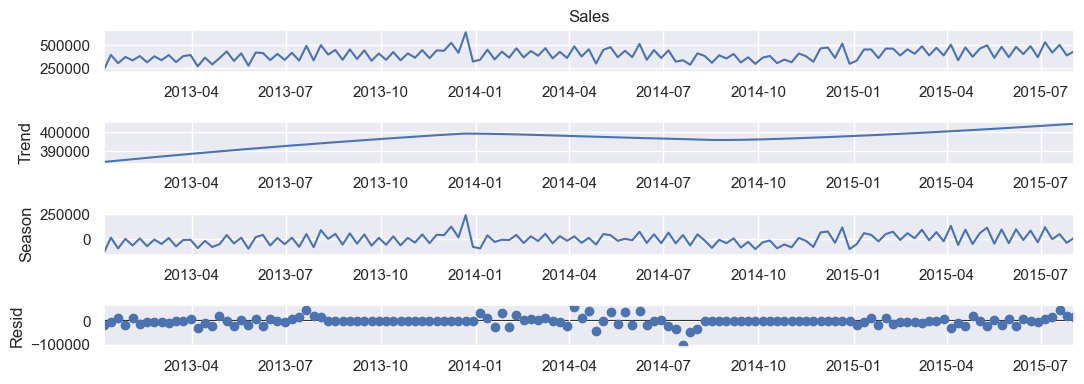

In [12]:
# Plot the data decomposed.

componentes = STL(weekly['Sales']).fit()
componentes.plot()
plt.show()

Observamos como el componente estacional no es tan claro como en la serie diaria, sin embargo, podemos ver como anualmente tiene una subida de ventas a final de año. Respecto a la tendencia, eslineal, pero al final del periodo vemos como han aumentado el nº de ventas a prácticamente el doble.

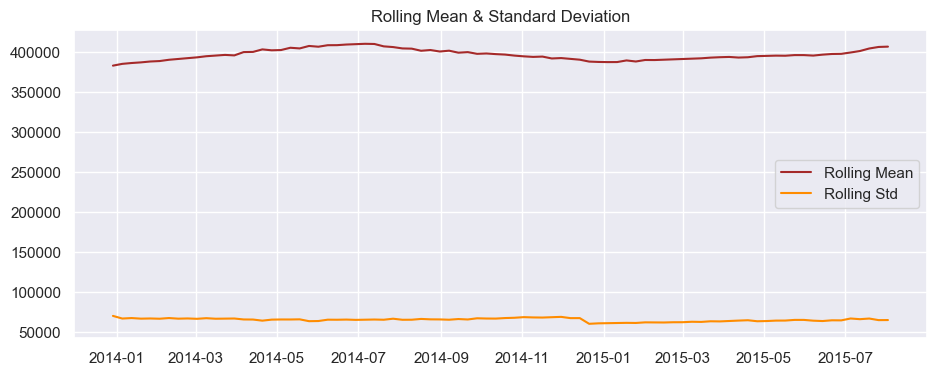

In [19]:
# Plot the rolmean and rolstd.

rolmean = weekly['Sales'].rolling(window=52).mean()
rolstd = weekly['Sales'].rolling(window=52).std()

plt.plot(rolmean, color='brown', label='Rolling Mean')
plt.plot(rolstd, color='darkorange', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

Observamos como tanto la media movil y la desviación estandar movil se mantienen estables de una forma más suave que la serie diaria, por lo que definitivamente confirmamos que la serie temporal es estacionaria tanto en media como en varianza.

## <a name="modelos"> 4. Pruebas de modelos <a>

Para la predicción de la serie temporal semanal, procederemos a probar modelos que funcionen correctamente con series temporales estacionarias como : ETS, ARIMA, THETA y TBATS. 

El modelo Prophet utilizado durante las predicciones diarias al ser el que mejor resultado nos dió será el primero que probaremos.

### 4.1 Prophet 

Vamos a comprobar como no es eficiente el realizado anteriormente. Para ello transformamos las columnas para que el modelo identifique las fechas y objetivo a predecir.

In [152]:
# Copy the index with a column named ds.

weekly['ds'] = weekly.index

# Rename the columns date and sales.

weekly_p = weekly.rename(columns={'Sales': 'y'})

# Display the first 3 rows of data.

weekly_p.head(3)

,DayOfWeek,y,Customers,Open,Promo,SchoolHoliday,ds
2013-01-06,270,227030,27671,36,0,40,2013-01-06
2013-01-13,280,395390,45616,54,50,0,2013-01-13
2013-01-20,280,305576,38441,54,0,0,2013-01-20


Separamos en train y test:

In [19]:
# Split the data into train and test.

train = weekly_p.iloc[:101,:]
test = weekly_p.iloc[101:,:]

Creamos el modelo:

11:42:29 - cmdstanpy - INFO - Chain [1] start processing
11:42:30 - cmdstanpy - INFO - Chain [1] done processing


-6.332293907807433


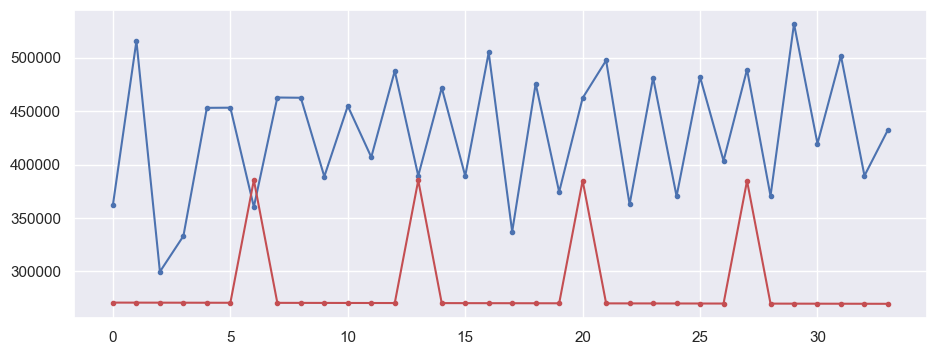

In [21]:
# Create the model

m = Prophet()

# Add the seasonality.

m.add_seasonality(name='weekly', period=7, fourier_order=3)

# Fit the model.

m.fit(train)

# Create the future dataframe.

future = m.make_future_dataframe(periods=len(test))

# Predict the test period

forecast = m.predict(future)

# Print the r2 metric.

print(r2_score(list(test['y']), list(forecast.loc[101:,'yhat'] )))


#Plot the forecast compared to the actual values.
plt.plot(list(test['y']),'.-')
plt.plot(list(forecast.loc[101:,'yhat']),'r.-')
plt.show()

Observamos como el modelo Prophet, el cual utilizamos para predecir la serie semanal no funciona correctamente.

### 4.2. Modelo ETS 

Cargamos los datos semanales:

In [73]:
# Load the data:

week_ets = weekly['Sales'].astype('float64').to_period('W')

Observamos el nº de filas para separar en train y test:

In [72]:
week_ets.shape

(135,)

Dividiremos los sets en train y test. Por ello seleccionaremos el 10% de los datos finales como test.

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='Sales'>)

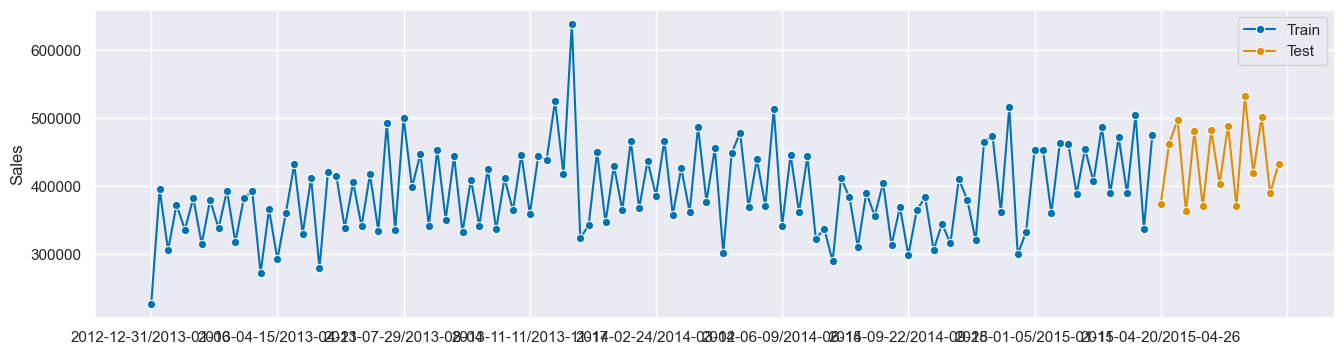

In [154]:
# Split in train and test.

ts_train, ts_test = week_ets[:120],week_ets[120:]

# Plot Train and test.

plot_series(ts_train, ts_test, labels=["Train", "Test"])


Para lograr el modelo qu emejor se ajuste lanzaremos un grid para entrenar el modelo:

In [155]:
# Inputs: transformaciones y modelos
pipe = TransformedTargetForecaster(steps=[
    ("forecaster", NaiveForecaster())])
# Defenir el CV
cv = ExpandingWindowSplitter(
    initial_window=60,
     step_length=1,
     fh=fh_test)
# definir los modelos y los parametros (GRID)
gscv = ForecastingGridSearchCV(
     forecaster=pipe,
    param_grid=[{
         "forecaster": [NaiveForecaster(sp=52)],
         "forecaster__strategy": ["drift", "last", "mean"],
     },
     {
          "forecaster": [ExponentialSmoothing(sp=52)],
          "forecaster__trend": ["add", "mul"],
          "forecaster__damped_trend": [True,False],
          "forecaster__seasonal": ["add", "mul"],
    },
     ],
     cv=cv,
     verbose=1,
     n_jobs=-1)

In [89]:
gscv.fit(ts_train)  

Fitting 46 folds for each of 11 candidates, totalling 506 fits


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                                                   initial_window=60),
                        forecaster=TransformedTargetForecaster(steps=[('forecaster',
                                                                       NaiveForecaster())]),
                        n_jobs=-1,
                        param_grid=[{'forecaster': [NaiveForecaster(sp=52)],
                                     'forecaster__strategy': ['drift', 'last',
                                                              'mean']},
                                    {'forecaster': [ExponentialSmoothing(sp=52)],
                                     'forecaster__damped_trend': [True, False],
                                     'forecaster__seasonal': ['add', 'mul'],
                                     'forecaster__trend': ['add', 'mul']}],
                        verbose=1)

Comprobamos que modelo es el que mejor se comporta para predecir el test, obtener las métricas y evaluar el modelo

In [90]:
# El mejor modelo
gscv.best_forecaster_

TransformedTargetForecaster(steps=[('forecaster',
                                    ExponentialSmoothing(damped_trend=True,
                                                         seasonal='add', sp=52,
                                                         trend='mul'))])

In [92]:
ets_cv_pred = gscv.predict(fh=fh_test) 



2015-04-20/2015-04-26    329560.017587
2015-04-27/2015-05-03    479668.798351
2015-05-04/2015-05-10    511308.440167
2015-05-11/2015-05-17    404064.071825
2015-05-18/2015-05-24    477033.357936
2015-05-25/2015-05-31    410806.377525
2015-06-01/2015-06-07    555015.160197
2015-06-08/2015-06-14    386459.618400
2015-06-15/2015-06-21    493924.673915
2015-06-22/2015-06-28    412547.024414
2015-06-29/2015-07-05    473184.689530
2015-07-06/2015-07-12    389626.852144
2015-07-13/2015-07-19    548586.326008
2015-07-20/2015-07-26    392279.415382
2015-07-27/2015-08-02    558010.194678
Freq: W-SUN, dtype: float64

Mostramos el MAPE y MAE y representamos graficamente las predicciones vs los datos originales.

MAE: 48694.62223683201
MAPE: 0.0871014379024598


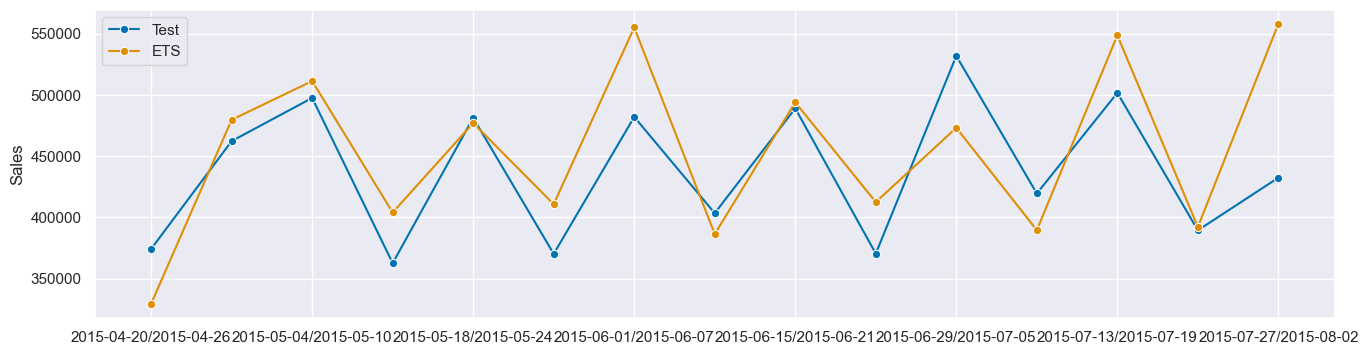

In [93]:
# Plot the test and the prediction.

plot_series(ts_test, ets_cv_pred, labels=["Test", "ETS"])

# Check the MAE and MAPE.

print('MAE:', mean_squared_error(ts_test, ets_cv_pred, squared=False))

print('MAPE:', mean_absolute_percentage_error(ts_test, ets_cv_pred))

Graficamos la predicción con el total de la serie temporal.

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='Sales'>)

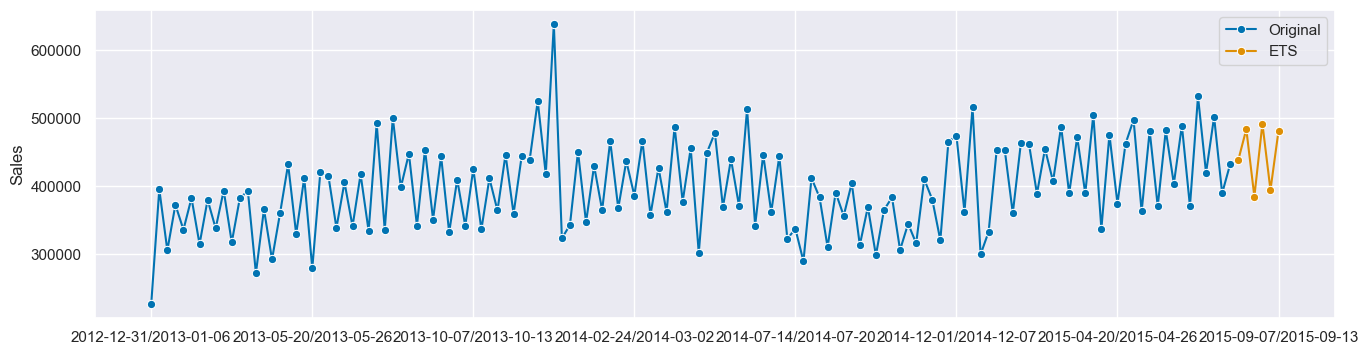

In [103]:
# Plot the weekly series and ets_pred.

plot_series(week_ets, ets_pred, labels=["Original", "ETS"])


### 4.3. Modelo ARIMA.

Realizamos una transformación logarítmica de los datos para realizar el modelo ARIMA:

<AxesSubplot: >

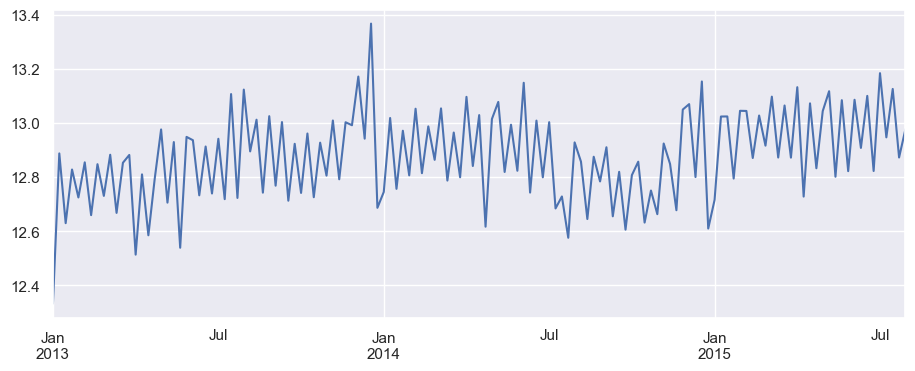

In [106]:
# Create log data from weekly.

log_weekly = np.log(weekly['Sales'])

# Plot the log data.

log_weekly.plot()


Lo separamos en train y test, para entrenar el modelo:

In [109]:
# Split into train and test.

log_ts_train, log_ts_test = temporal_train_test_split(y =log_weekly, test_size=15)

# Define the model.

arima_model = StatsForecastAutoARIMA(sp=52)

# Train the model.

arima_model.fit(log_ts_train) 


StatsForecastAutoARIMA(sp=52)

In [110]:
 # Set forecast horizon.

fh_test=np.arange(1,len(ts_test)+1)

 # Predict on test period.

log_arima_pred = arima_model.predict(fh=fh_test)

# Display the MAE and MAPE.

log_arima_pred

2015-04-26    12.594239
2015-05-03    13.028581
2015-05-10    13.071494
2015-05-17    12.823894
2015-05-24    12.992306
2015-05-31    12.825598
2015-06-07    13.148709
2015-06-14    12.744107
2015-06-21    13.009416
2015-06-28    12.800303
2015-07-05    13.003758
2015-07-12    12.685193
2015-07-19    12.729392
2015-07-26    12.576858
2015-08-02    12.929164
dtype: float64

MAE: 68133.4603924904
MAPE: 0.1157941167588396


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='Sales'>)

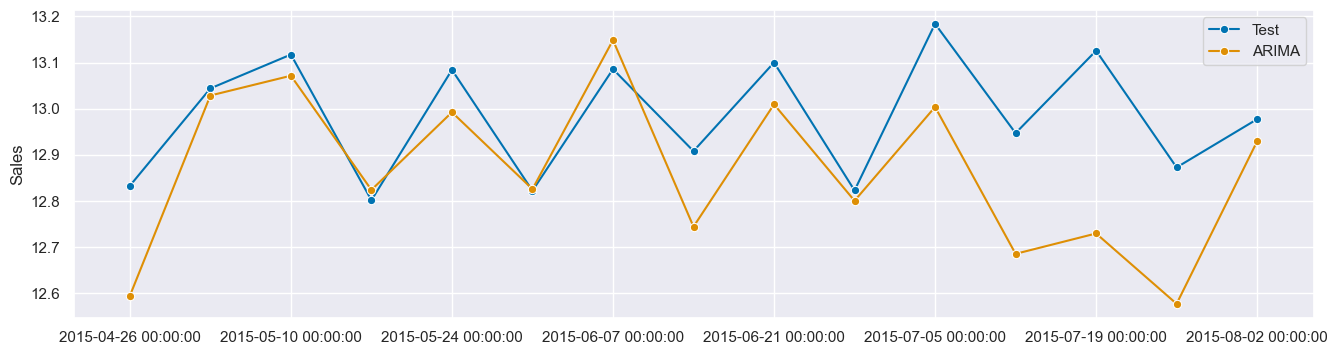

In [156]:
# Check the MAE and MAPE of the log data transformed.

print('MAE:', mean_squared_error(np.exp(log_ts_test), np.exp(log_arima_pred), squared=False))

print('MAPE:', mean_absolute_percentage_error(np.exp(log_ts_test), np.exp(log_arima_pred)))

# Plot the test and the prediction.

plot_series(log_ts_test, log_arima_pred, labels=["Test", "ARIMA"])



Observamos como el modelo Arima tiene un error mayor que el ETS.

## 4.4. Theta

Comenzamos separando en train y test los datos:

In [119]:
# Load the weekly data.

week_theta = weekly['Sales'].astype('float64').to_period('W')

# Split train and test.

week_theta_train, week_theta_test = week_theta[:120],week_theta[120:]

Entrenamos el modelo:

In [121]:

# Define the model.

theta_model = ThetaForecaster(sp=52)

# Train the model

theta_model.fit(week_theta_train) 

ThetaForecaster(sp=52)

Marcamos el horizonte temporal  apredecir y obtenemos las métricas.

MAE: 44331.593924181034
MAPE: 0.0879687152898097


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='Sales'>)

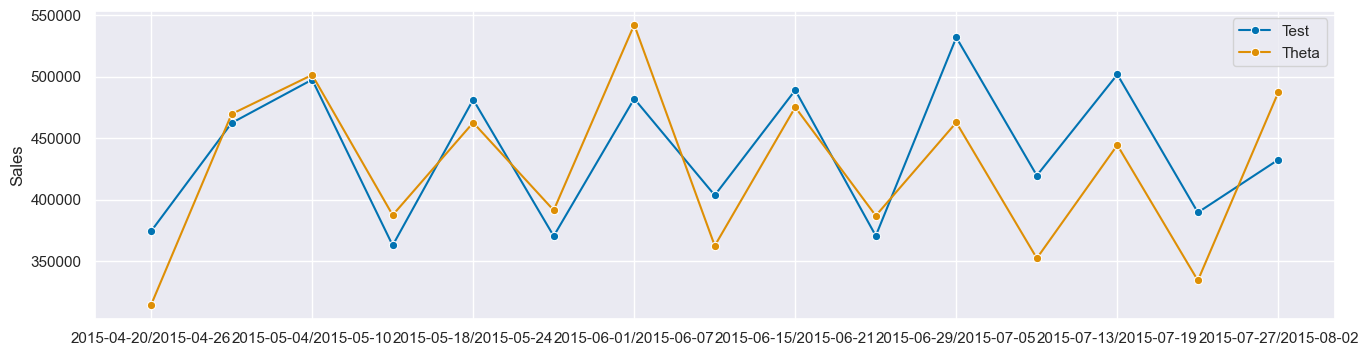

In [157]:
# Define the forecast horizon.

theta_pred = theta_model.predict(fh=fh_test)

# Print the MAE and MAPE.

print('MAE:', mean_squared_error(week_theta_test, theta_pred, squared=False))

print('MAPE:', mean_absolute_percentage_error(week_theta_test, theta_pred))

# Plot the test and the prediction.

plot_series(week_theta_test, theta_pred, labels=["Test", "Theta"])

Observamos que el Theta se comporta bastante bien, aunque ligeramente pero que el ETS.

## 4.5. TBATS

Con el train y test separado anteriormente para el modelo Theta, creamos un grid para obtener el modelo que mejor se comporta.

In [131]:
# Inputs: transformaciones y modelos
pipe = TransformedTargetForecaster(steps=[
    ("forecaster", NaiveForecaster())])
# Defenir el CV
cv = ExpandingWindowSplitter(
    initial_window=60,
     step_length=1,
     fh=fh_test)
# definir los modelos y los parametros (GRID)
gscv = ForecastingGridSearchCV(
     forecaster=pipe,
    param_grid=[{
         "forecaster": [NaiveForecaster(sp=52)],
         "forecaster__strategy": ["drift", "last", "mean"],
     },
     {
          "forecaster": [TBATS(sp=52,n_jobs=1,use_arma_errors=True)],
          "forecaster__use_trend":[True,False],
          "forecaster__use_damped_trend": [True,False],
          "forecaster__use_box_cox": [True,False],
    },
     ],
     cv=cv,
     verbose=1,
     n_jobs=-1)

Entrenamos el modelo qu emejor se ha comportado:

In [132]:
# Train the model.

gscv.fit(week_theta_train)  

Fitting 46 folds for each of 11 candidates, totalling 506 fits


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                                                   initial_window=60),
                        forecaster=TransformedTargetForecaster(steps=[('forecaster',
                                                                       NaiveForecaster())]),
                        n_jobs=-1,
                        param_grid=[{'forecaster': [NaiveForecaster(sp=52)],
                                     'forecaster__strategy': ['drift', 'last',
                                                              'mean']},
                                    {'forecaster': [TBATS(n_jobs=1, sp=52)],
                                     'forecaster__use_box_cox': [True, False],
                                     'forecaster__use_damped_trend': [True,
                                                                      False],
                                     'forecaster__use_trend': [True, False]}],
                        verbose=1)

Procedemos a predecir sobre el periodo de test:

In [136]:
# Prediction
tbats_cv_pred = gscv.predict(fh=fh_test) 
tbats_cv_pred

2015-04-20/2015-04-26    397668.126480
2015-04-27/2015-05-03    448102.669838
2015-05-04/2015-05-10    425544.903442
2015-05-11/2015-05-17    439287.511765
2015-05-18/2015-05-24    428336.600763
2015-05-25/2015-05-31    430337.235085
2015-06-01/2015-06-07    428074.036338
2015-06-08/2015-06-14    432012.699292
2015-06-15/2015-06-21    432955.271110
2015-06-22/2015-06-28    430707.758569
2015-06-29/2015-07-05    422156.273373
2015-07-06/2015-07-12    411076.778149
2015-07-13/2015-07-19    402321.152878
2015-07-20/2015-07-26    401120.292844
2015-07-27/2015-08-02    408307.765876
Freq: W-SUN, dtype: float64

In [138]:
# Check the MAE and MAPE.

print('MAE:', mean_squared_error(week_theta_test, tbats_cv_pred, squared=False))

print('MAPE:', mean_absolute_percentage_error(week_theta_test, tbats_cv_pred))


MAE: 58522.00935705462
MAPE: 0.11271190526443539


El modelo se comporta pero que otros modelos realizados anteriormente, al tener un error más grande.

## <a name="prediccion"> 5. Predicción a futuro <a>

Una vez realizados diferentes modelos nos quedaremos con aquel que mejor se ha comportado para predecir las 6 semanas siguientes. Para ello vamos a resumir los resultados de los modelos en una tabla:

In [162]:
# Create  a dataframe with the MAPES of each model.

mapes = pd.DataFrame({'MAPE': [0.0871,0.1157,0.0879,0.1127]},
                    index=['ETS', 'ARIMA', 'Theta', 'TBATS'])

# Sort the values.

mapes.sort_values(by='MAPE')

,MAPE
ETS,0.0871
Theta,0.0879
TBATS,0.1127
ARIMA,0.1157


EL ETS es el modelo que mejor se ha comportado por lo que procedemos a la predicción a futuro de 6 semanas. Para ello usaremos el modelo con los parámetros resultado nos calculó.

In [163]:
# Set up the model.

ets_future = ExponentialSmoothing(damped_trend=True,seasonal='add', sp=52,trend='mul')

# Train the model.

ets_future.fit(week_ets)  

ExponentialSmoothing(damped_trend=True, seasonal='add', sp=52, trend='mul')

Procedemos a predecir las seis semanas siguientes.

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='Sales'>)

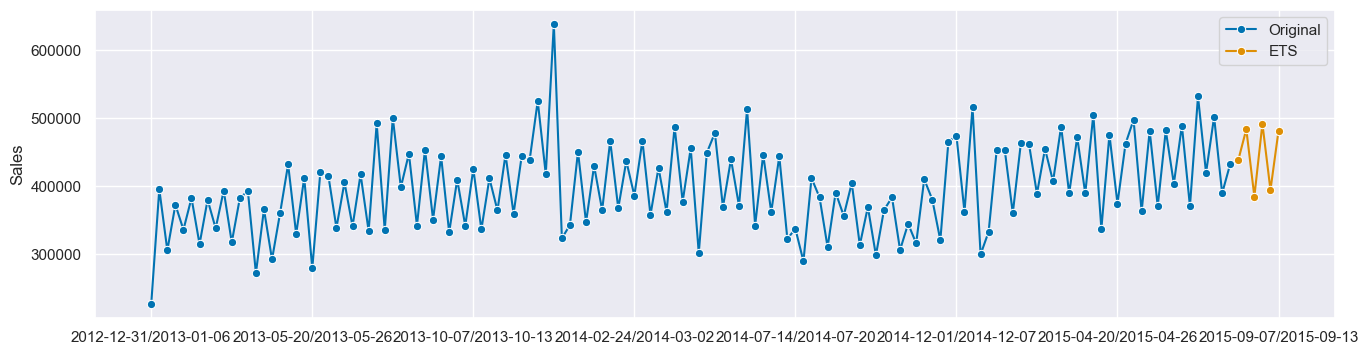

In [165]:
# Predict the next 6 weeks.

ets_pred = ets_future.predict(fh=[ 1,  2,  3,  4,  5,  6,]) 

#Show the prediction.

ets_pred

# Plot the weekly series and ets_pred.

plot_series(week_ets, ets_pred, labels=["Original", "ETS"])


Una vez realizadas las predicciones, realizamos una transformación para convertirlo a números enteros y lo guardamos en un csv.

In [168]:
# Conevert to integer the prediction.

ets_pred = ets_pred.astype(int)

# Save ets_pred in a csv file without index.

ets_pred.to_csv('weekly_pred.csv', index=False)